In [1]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib yfinance matplotlib yfinance numpy scikit-learn river scikit-optimize pysqlite3


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics

# Importando as classes refatoradas
from utils.SeriesProcessor import SeriesProcessor
from utils.ModelTrainer import ModelTrainer
from utils.DriftEvaluator import DriftEvaluator
from utils.Visualizer import Visualizer
from utils.Optimizer import Optimizer

# Importando as classes existentes de otimização
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1. Importar os modelos e detectores de drift

In [4]:
# Importando detectores de drift
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
#from classes.detectores.KSWINDetector import KSWINDetector

# Importando modelos offline
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

# Importando modelos online
from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# 2. Baixar e preparar os dados

In [5]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [6]:
# Definindo parâmetros para processamento
tamanho_batch = 50
lags = 5
serie_escolhida = series[-2]
print(f"Processando série: {serie_escolhida}")

# Baixando os dados da ação
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Processando série: ^BVSP
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1245, 1)
Shape dos dados de entrada: (1240, 5)
Shape dos dados de saída: (1240, 1)


# 3. Otimização de Hiperparâmetros

In [7]:
# Controle para executar ou pular otimização
executar_otimizacao = True #Mude para True quando quiser otimizar novamente

if executar_otimizacao:
    # Lista de modelos a otimizar (classes)
    modelos_offline = [
        LinearRegressionModelo,
        KNeighborsRegressorModelo,
        LassoRegressionModelo,
        #MLPRegressorModelo,  # Comentado por ser mais lento
        RandomForestModelo,
        RidgeRegressionModelo,
        SVRModelo
    ]

    modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

    # Inicializar o otimizador
    optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)

    # Otimizando todos os modelos
    modelos_otimizados, parametros_otimizados = Optimizer.otimizar_modelos_offline(
        X, Y, tamanho_batch, lags=lags, optimizer=optimizer,
        modelos_offline=modelos_offline,
    )

    # Salvar parâmetros otimizados para uso futuro
    import json
    with open('parametros_otimizados.json', 'w') as f:
        # Converter valores não serializáveis para strings
        params_serializaveis = {}
        for modelo, params in parametros_otimizados.items():
            params_serializaveis[modelo] = {k: str(v) for k, v in params.items()}
        json.dump(params_serializaveis, f, indent=4)

    print("Parâmetros otimizados salvos em 'parametros_otimizados.json'")
else:
    # Carregar parâmetros já otimizados
    import json
    import os
    import ast

    if os.path.exists('parametros_otimizados.json'):
        with open('parametros_otimizados.json', 'r') as f:
            params_carregados = json.load(f)

        # Convertendo strings de volta para valores adequados
        parametros_otimizados = {}
        for modelo, params in params_carregados.items():
            parametros_otimizados[modelo] = {}
            for k, v in params.items():
                # Tenta converter strings para valores Python
                try:
                    parametros_otimizados[modelo][k] = ast.literal_eval(v)
                except (ValueError, SyntaxError):
                    # Se falhar, mantém como string
                    parametros_otimizados[modelo][k] = v

        # Instanciando modelos com parâmetros otimizados
        modelos_otimizados = {}

        # Dicionário para mapear nomes de classes para referências reais de classes
        classes_modelos = {
            cls.__name__: cls for cls in
            [LinearRegressionModelo, KNeighborsRegressorModelo, LassoRegressionModelo,
             RandomForestModelo, RidgeRegressionModelo, SVRModelo,
             BayesianLinearRegressionModelo, HoeffdingTreeRegressorModelo,
             KNNRegressorOnlineModelo, LinearRegressionOnlineModelo]
        }

        for nome_modelo, params in parametros_otimizados.items():
            # Extrai o nome da classe do nome do modelo
            nome_classe = nome_modelo.split('_')[0]
            if nome_classe in classes_modelos:
                classe_modelo = classes_modelos[nome_classe]
                modelos_otimizados[nome_modelo] = classe_modelo(**params)
            else:
                print(f"Aviso: Classe {nome_classe} não encontrada!")

        print(f"Carregados {len(modelos_otimizados)} modelos com parâmetros otimizados")
    else:
        print("Arquivo de parâmetros não encontrado. Execute a otimização primeiro.")


Otimizando LinearRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [False, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [False, False, False] before, using random point [True, False, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando KNeighborsRegressorModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.837e-01, tolerance: 5.813e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+00, tolerance: 9.717e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando RandomForestModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector 


Otimizando RidgeRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Parâmetros otimizados salvos em 'parametros_otimizados.json'


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# TODO: Depois remover essa parte do código porque aqui é somente um verificador de parâmetros dos modelos
for nome_modelo, modelo_instancia in modelos_otimizados.items():
    print(f"Modelo: {nome_modelo}")

    # Verificando se é um modelo offline ou online
    if hasattr(modelo_instancia, 'modelo'):
        # Para modelos que têm um atributo 'modelo' que encapsula o modelo real
        if hasattr(modelo_instancia.modelo, 'get_params'):
            params = modelo_instancia.modelo.get_params()
            print("Parâmetros:")
            for param, valor in params.items():
                print(f"  - {param}: {valor}")
        else:
            # Se não tiver método get_params
            print(f"Configuração interna: {modelo_instancia.modelo}")
    else:
        # Tentativa direta de obter parâmetros
        if hasattr(modelo_instancia, 'get_params'):
            params = modelo_instancia.get_params()
            print("Parâmetros:")
            for param, valor in params.items():
                print(f"  - {param}: {valor}")
        else:
            print(f"Informações disponíveis: {modelo_instancia}")

    print("-" * 50)

Modelo: LinearRegressionModelo
Parâmetros:
  - copy_X: False
  - fit_intercept: False
  - n_jobs: None
  - positive: True
--------------------------------------------------
Modelo: KNeighborsRegressorModelo
Parâmetros:
  - algorithm: auto
  - leaf_size: 30
  - metric: minkowski
  - metric_params: None
  - n_jobs: None
  - n_neighbors: 6
  - p: 2
  - weights: distance
--------------------------------------------------
Modelo: LassoRegressionModelo
Parâmetros:
  - alpha: 0.0019038278424277919
  - copy_X: True
  - fit_intercept: True
  - max_iter: 2000
  - positive: False
  - precompute: False
  - random_state: None
  - selection: cyclic
  - tol: 1e-06
  - warm_start: False
--------------------------------------------------
Modelo: RandomForestModelo
Parâmetros:
  - bootstrap: True
  - ccp_alpha: 0.0
  - criterion: squared_error
  - max_depth: 6
  - max_features: 1.0
  - max_leaf_nodes: None
  - max_samples: None
  - min_impurity_decrease: 0.0
  - min_samples_leaf: 1
  - min_samples_split

# 4. Executando Avaliação Prequential com Detecção de Drift

In [9]:
# Detector de drift a ser usado
detector_escolhido = ADWINDetector

# Executando prequential com os modelos otimizados
resultados = {}
deteccoes_por_modelo = {}

for nome_modelo, modelo in modelos_otimizados.items():
    print(f"\nExecutando prequential para {nome_modelo}...")
    predicoes, deteccoes = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=type(modelo), detector_classe=detector_escolhido)
    resultados[nome_modelo] = predicoes
    deteccoes_por_modelo[nome_modelo] = deteccoes  # Armazena as detecções

    print(f"Número de detecções para {nome_modelo}: {len(deteccoes)}")


Executando prequential para LinearRegressionModelo...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7c46a5c9a720>
MAE Modelo Batch: [0.09130604]
Desvio Padrão dos Erros: 0.0729051371154861
Número de detecções para LinearRegressionModelo: 0

Executando prequential para KNeighborsRegressorModelo...

Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo u

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7c46a5d8c8c0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7c46a5250080>
MAE Modelo Batch: 0.49555011525957315
Desvio Padrão dos Erros: 0.5397236604124316
Número de detecções para RandomForestModelo: 4

Executando prequential para RidgeRegressionModelo...
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x7c46a5dba210>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7c46a5369ac0>
MAE Modelo Batch: 0.10140593227412213
Desvio Padrão dos Erros: 0.07743345031981437
Número de detecções para RidgeRegressionModelo: 0

Executando prequential para SVRModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v


Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo utilizado: <classes.modelosOffline.SVRModelo.SVRModelo object at 0x7c46a5f06600>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7c46a536a0f0>
MAE Modelo Batch: 0.6693660155958437
Desvio Padrão dos Erros: 0.6820318344344984
Número de detecções para SVRModelo: 4


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Nenhum drift detectado para LinearRegressionModelo.

Drift detectado para KNeighborsRegressorModelo nos índices: [176, 448, 656, 928]

Drift detectado para LassoRegressionModelo nos índices: [176, 448, 656, 928]

Drift detectado para RandomForestModelo nos índices: [176, 448, 656, 928]

Nenhum drift detectado para RidgeRegressionModelo.

Drift detectado para SVRModelo nos índices: [176, 448, 656, 928]


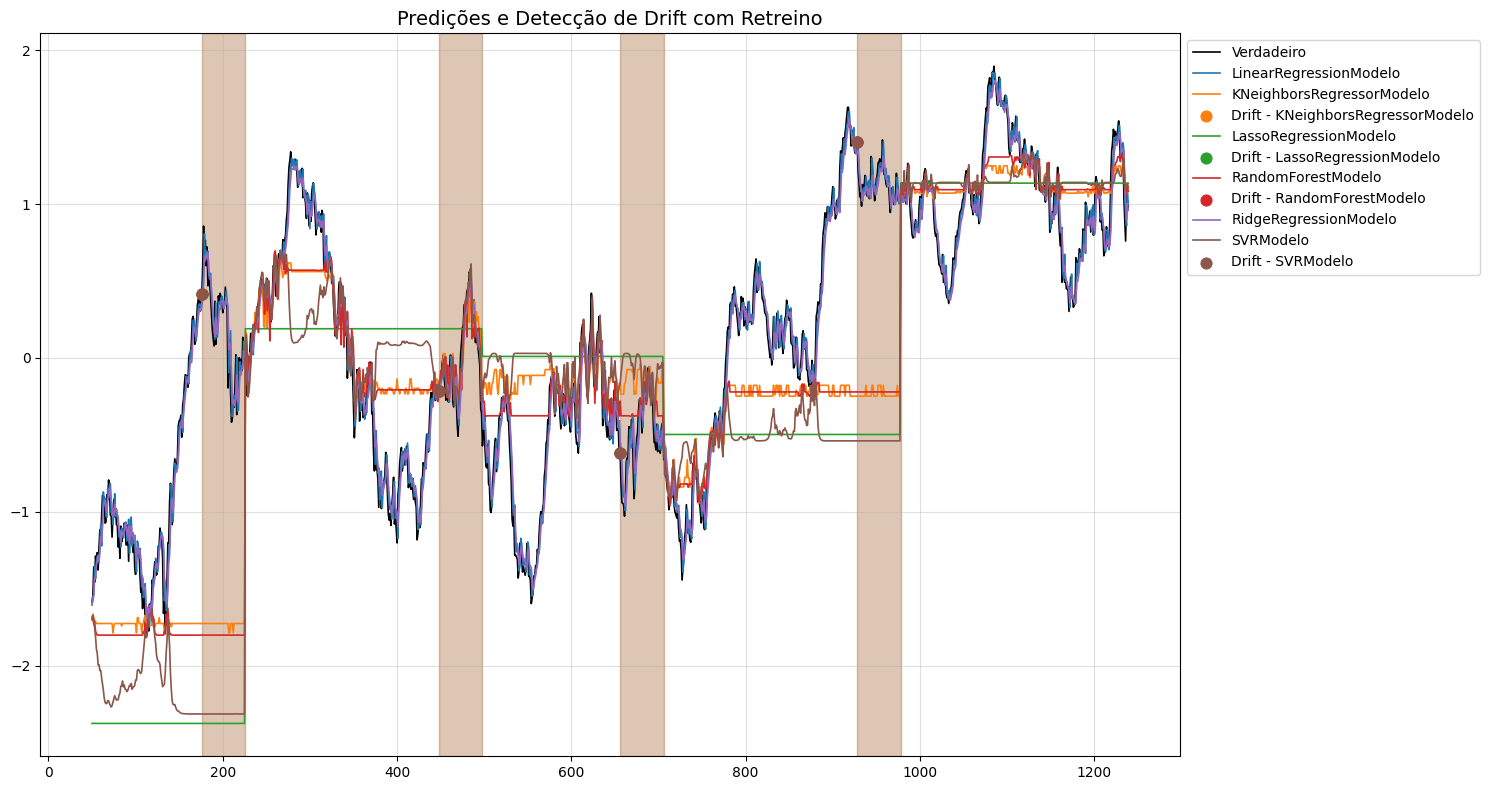

In [10]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  list(resultados.values()),
                  list(resultados.keys()),
                  deteccoes_por_modelo,
                  tamanho_batch)

# 5. Comparação de Detectores de Drift

In [11]:
# Selecionando um modelo para testar com diferentes detectores
modelo_escolhido = RandomForestModelo
print(f"Modelo selecionado para testes comparativos: {modelo_escolhido.__name__}")

# Lista de detectores a testar
detectores = [
    ADWINDetector,
    #DDMDetector,
    EDDMDetector,
    FHDDMDetector,
    HDDM_ADetector,
    PageHinkleyDetector
]

resultados_detectores = {}
deteccoes_detectores = {}

for detector in detectores:
    nome_detector = detector.__name__
    print(f"\nTestando {nome_detector}...")
    predicoes, deteccoes = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=modelo_escolhido, detector_classe=detector)
    resultados_detectores[nome_detector] = predicoes
    deteccoes_detectores[nome_detector] = deteccoes
    print(f"Número de detecções para {nome_detector}: {len(deteccoes)}")

Modelo selecionado para testes comparativos: RandomForestModelo

Testando ADWINDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7c46a5210290>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7c46a51d9460>
MAE Modelo Batch: 0.49544288305533074
Desvio Padrão dos Erros: 0.5347505156224763
Número de detecções para ADWINDetector: 4

Testando EDDMDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7c46a4f93320>
Detector utilizado: <classes.detectores.EDDMDetector.EDDMDetector object at 0x7c46a4f93740>
MAE Modelo Batch: 1.8982366202034326
Desvio Padrão dos Erros: 0.8636639593667974
Número de detecções para EDDMDetector: 0

Testando FHDDMDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 375, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 374 até 424.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 740, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 739 até 789.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1189, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1188 até 1238.
Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7c46a5210290>
Detector utilizado: <classes.detectores.FHDDMDetector.FHDDMDetector object at 0x7c46a4f91640>
MAE Modelo Batch: 0.8302756224922818
Desvio Padrão dos Erros: 0.7401171874497143
Número de detecções para FHDDMDetector: 3

Testando HDDM_ADetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 151, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 150 até 200.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 304, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 303 até 353.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 542, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 541 até 591.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 813, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 812 até 862.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 918, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 917 até 967.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1179, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1178 até 1228.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7c46a66042c0>
Detector utilizado: <classes.detectores.HDDM_ADetector.HDDM_ADetector object at 0x7c46a51db320>
MAE Modelo Batch: 0.4109584013746828
Desvio Padrão dos Erros: 0.4428393264299314
Número de detecções para HDDM_ADetector: 6

Testando PageHinkleyDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 186, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 185 até 235.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1005, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1004 até 1054.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7c46e03fcf20>
Detector utilizado: <classes.detectores.PageHinkleyDetector.PageHinkleyDetector object at 0x7c46a4f93710>
MAE Modelo Batch: 0.5109184064746666
Desvio Padrão dos Erros: 0.5086767611213395
Número de detecções para PageHinkleyDetector: 2



Drift detectado para ADWINDetector nos índices: [176, 448, 656, 928]

Nenhum drift detectado para EDDMDetector.

Drift detectado para FHDDMDetector nos índices: [375, 740, 1189]

Drift detectado para HDDM_ADetector nos índices: [151, 304, 542, 813, 918, 1179]

Drift detectado para PageHinkleyDetector nos índices: [186, 1005]


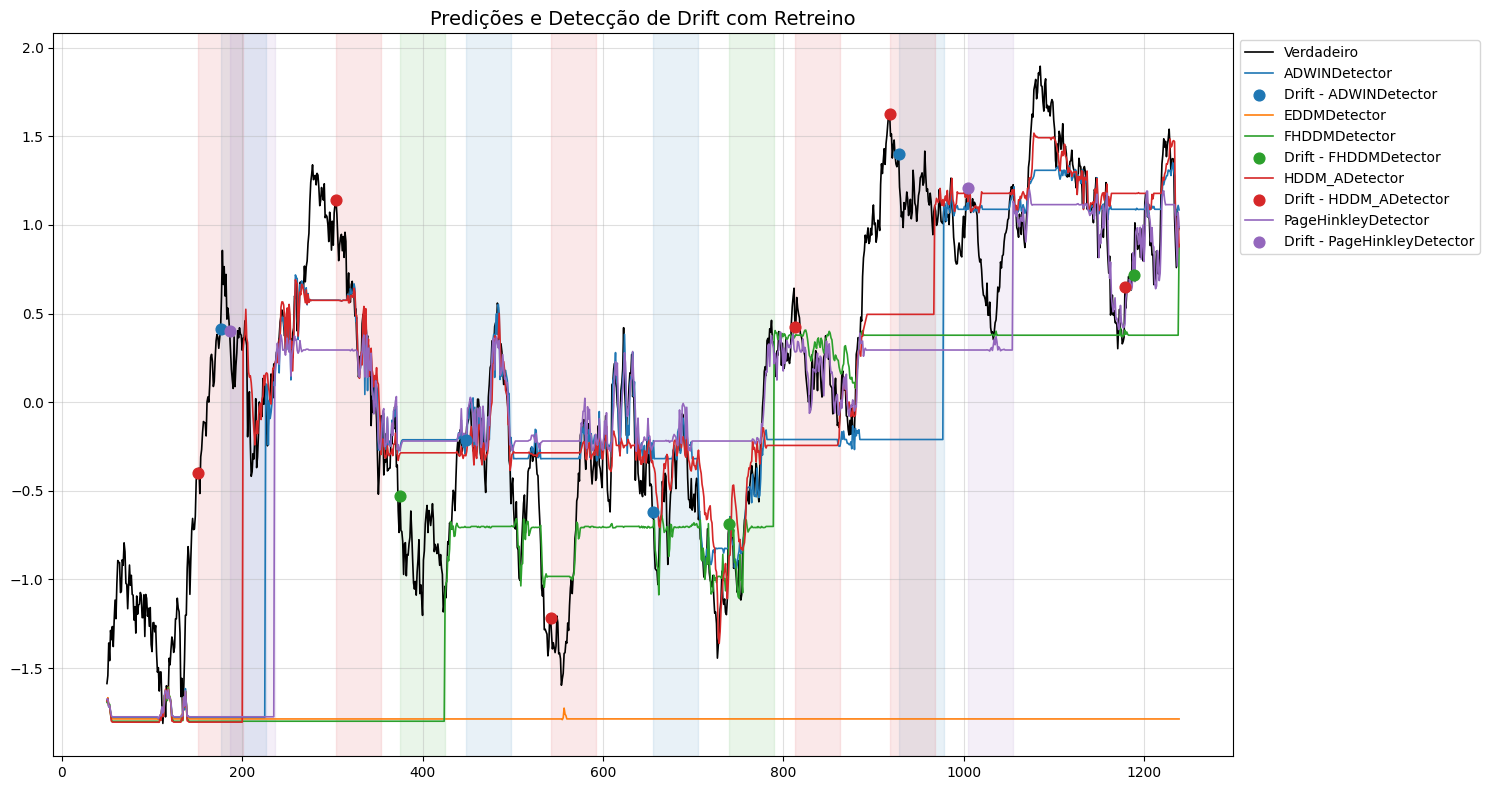

In [12]:
# Plotando comparação de detectores
Visualizer.plotar_resultados_multi(Y,
                  list(resultados_detectores.values()),
                  list(resultados_detectores.keys()),
                  deteccoes_detectores,
                  tamanho_batch)